In [1]:
#Imports.

import matplotlib.pyplot as plt
import numpy as np
import os.path
import refnx, scipy
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet
from refnx.dataset import ReflectDataset
import random
import tqdm
from monolayer import monolayer

seed = 1234
%matplotlib inline

In [2]:
#Define all the neutron b's
bc = 0.6646e-4;	
bo = 0.5804e-4;	
bh = -0.3739e-4;
bp = 0.513e-4
bn = 0.936e-4
bd = 0.6671e-4

#Formulae of the molecule sections
CH2 = (1*bc) + (2*bh);
CH = (1*bc) + (1*bh);
CH3 = (1*bc) + (3*bh);
D2O = (2*bd) + (1*bo);
H2O = (2*bh) + (1*bo);

sum_b_tails = (28*CH2) + (2*CH) + (2*CH3) 
sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
sum_b_heads = (1/4)*(3*(sum_popc_heads) + (sum_popg_heads)) 

vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
volume_tails = (nCH2 * vCH2) + (2 * vCH3)
volume_heads = 331

b_heads = Parameter(sum_b_heads, 'b_heads')
b_tails = Parameter(sum_b_tails, 'b_tails')

v_heads = Parameter(volume_heads, 'v_heads')
v_tails = Parameter(volume_tails, 'v_tails')

### Parameters

In [3]:
#Load in data. 

data_d2o = ReflectDataset('54696_97_d2o.txt')
data_pmw = ReflectDataset('54699_00_pmw.txt')

#Materials (Scattering Length Density)

d2o_sld = Parameter(6.062, 'd2o SLD', vary=True, bounds= (6,6.35))
pmw_sld = Parameter(2.206, 'pmw SLD', vary=True, bounds= (2,3))

d2o = SLD(d2o_sld, name = 'D2O') #D2O
pmw = SLD(pmw_sld, name = 'PMW') #PMW
air = SLD(0) #Air

#Structure
nWater = Parameter(11, vary = True, name = 'nWater', bounds = (5, 15))

apm = Parameter(60.88, 'area per molecule', vary=True, bounds=(57, 65))

head_thickness = Parameter(7.92, 'head_thickness', vary=True, bounds=(5.52, 13))
tail_thickness = Parameter(17.99, 'tail_thickness', vary=True, bounds=(13.67, 20.5))
roughness = Parameter(7.38, 'roughness', vary=True, bounds=(3.3, 10))
solv_rough = Parameter(4, 'solv rough', vary = True, bounds = (3.3,7))

#D2O slab
d2o_slab = d2o(0, solv_rough)
d2o_top = d2o(5, solv_rough)
d2o_top.thick.setp(7.95, vary = True, bounds = (5,15))

#PMW slab
pmw_slab = pmw(0, solv_rough)
pmw_top = pmw(5, solv_rough)
pmw_top.thick.setp(7.45, vary = True, bounds = (2,15))


### Model

In [4]:

topD2O = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness,
                    roughness, roughness, nWater = nWater, head_solvent = 'd2o')


bottomD2O = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness, 
                    roughness, roughness, nWater = nWater, head_solvent = 'd2o', reverse_monolayer=True)

topPMW = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness,
                    roughness, roughness, nWater = nWater, head_solvent = 'pmw')


bottomPMW = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness, 
                    roughness, roughness, nWater = nWater, head_solvent = 'pmw', reverse_monolayer=True)



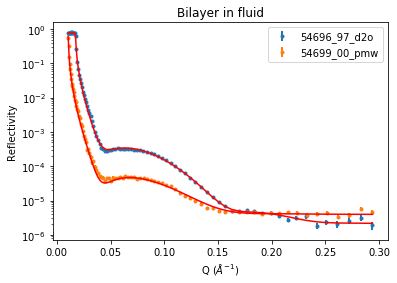

In [5]:
#Custom structure
structD2O = air | d2o_top | topD2O | bottomD2O | d2o_slab
structPMW = air | pmw_top | topPMW | bottomPMW | pmw_slab

scaleargs = dict(value = 0.7675, vary=True, bounds=(0.6, 0.8))
bkgargs = dict(value = 2.3e-6, vary=True, bounds=(1e-6, 5e-6))

modelD2O = ReflectModel(structD2O)
modelD2O.scale.setp(**scaleargs)
modelD2O.bkg.setp(**bkgargs)

modelPMW = ReflectModel(structPMW)
modelPMW.scale.setp(**scaleargs)
modelPMW.bkg.setp(**bkgargs)

objD2O = Objective(modelD2O, data_d2o)
objPMW = Objective(modelPMW, data_pmw)

globalObj = GlobalObjective([objD2O, objPMW])

fitCustom = CurveFitter(globalObj)
fitCustom.fit('differential_evolution')

globalObj.plot()
plt.title('Bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

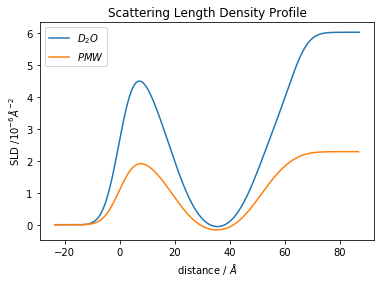

In [6]:
#SLD profile of structure.

plt.plot(*structD2O.sld_profile(), label = '$D_2O$')
plt.plot(*structPMW.sld_profile(), label = '$PMW$')
plt.title('Scattering Length Density Profile')
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.legend();

In [7]:
#print(globalObj.parameters)

### MCMC

In [8]:
#Burn frist 500, sample every 10th from 1000.

fitCustom.sample(500, nthin = 10, random_state = seed)
process_chain(globalObj, fitCustom.chain, nburn=200, flatchain=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/refnx/_lib/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [52:00<00:00,  1.60it/s]  


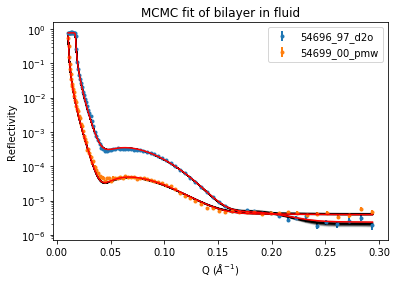

In [17]:
globalObj.plot(samples = 300)
plt.title('MCMC fit of bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.savefig('fitCustom.png')
plt.legend();

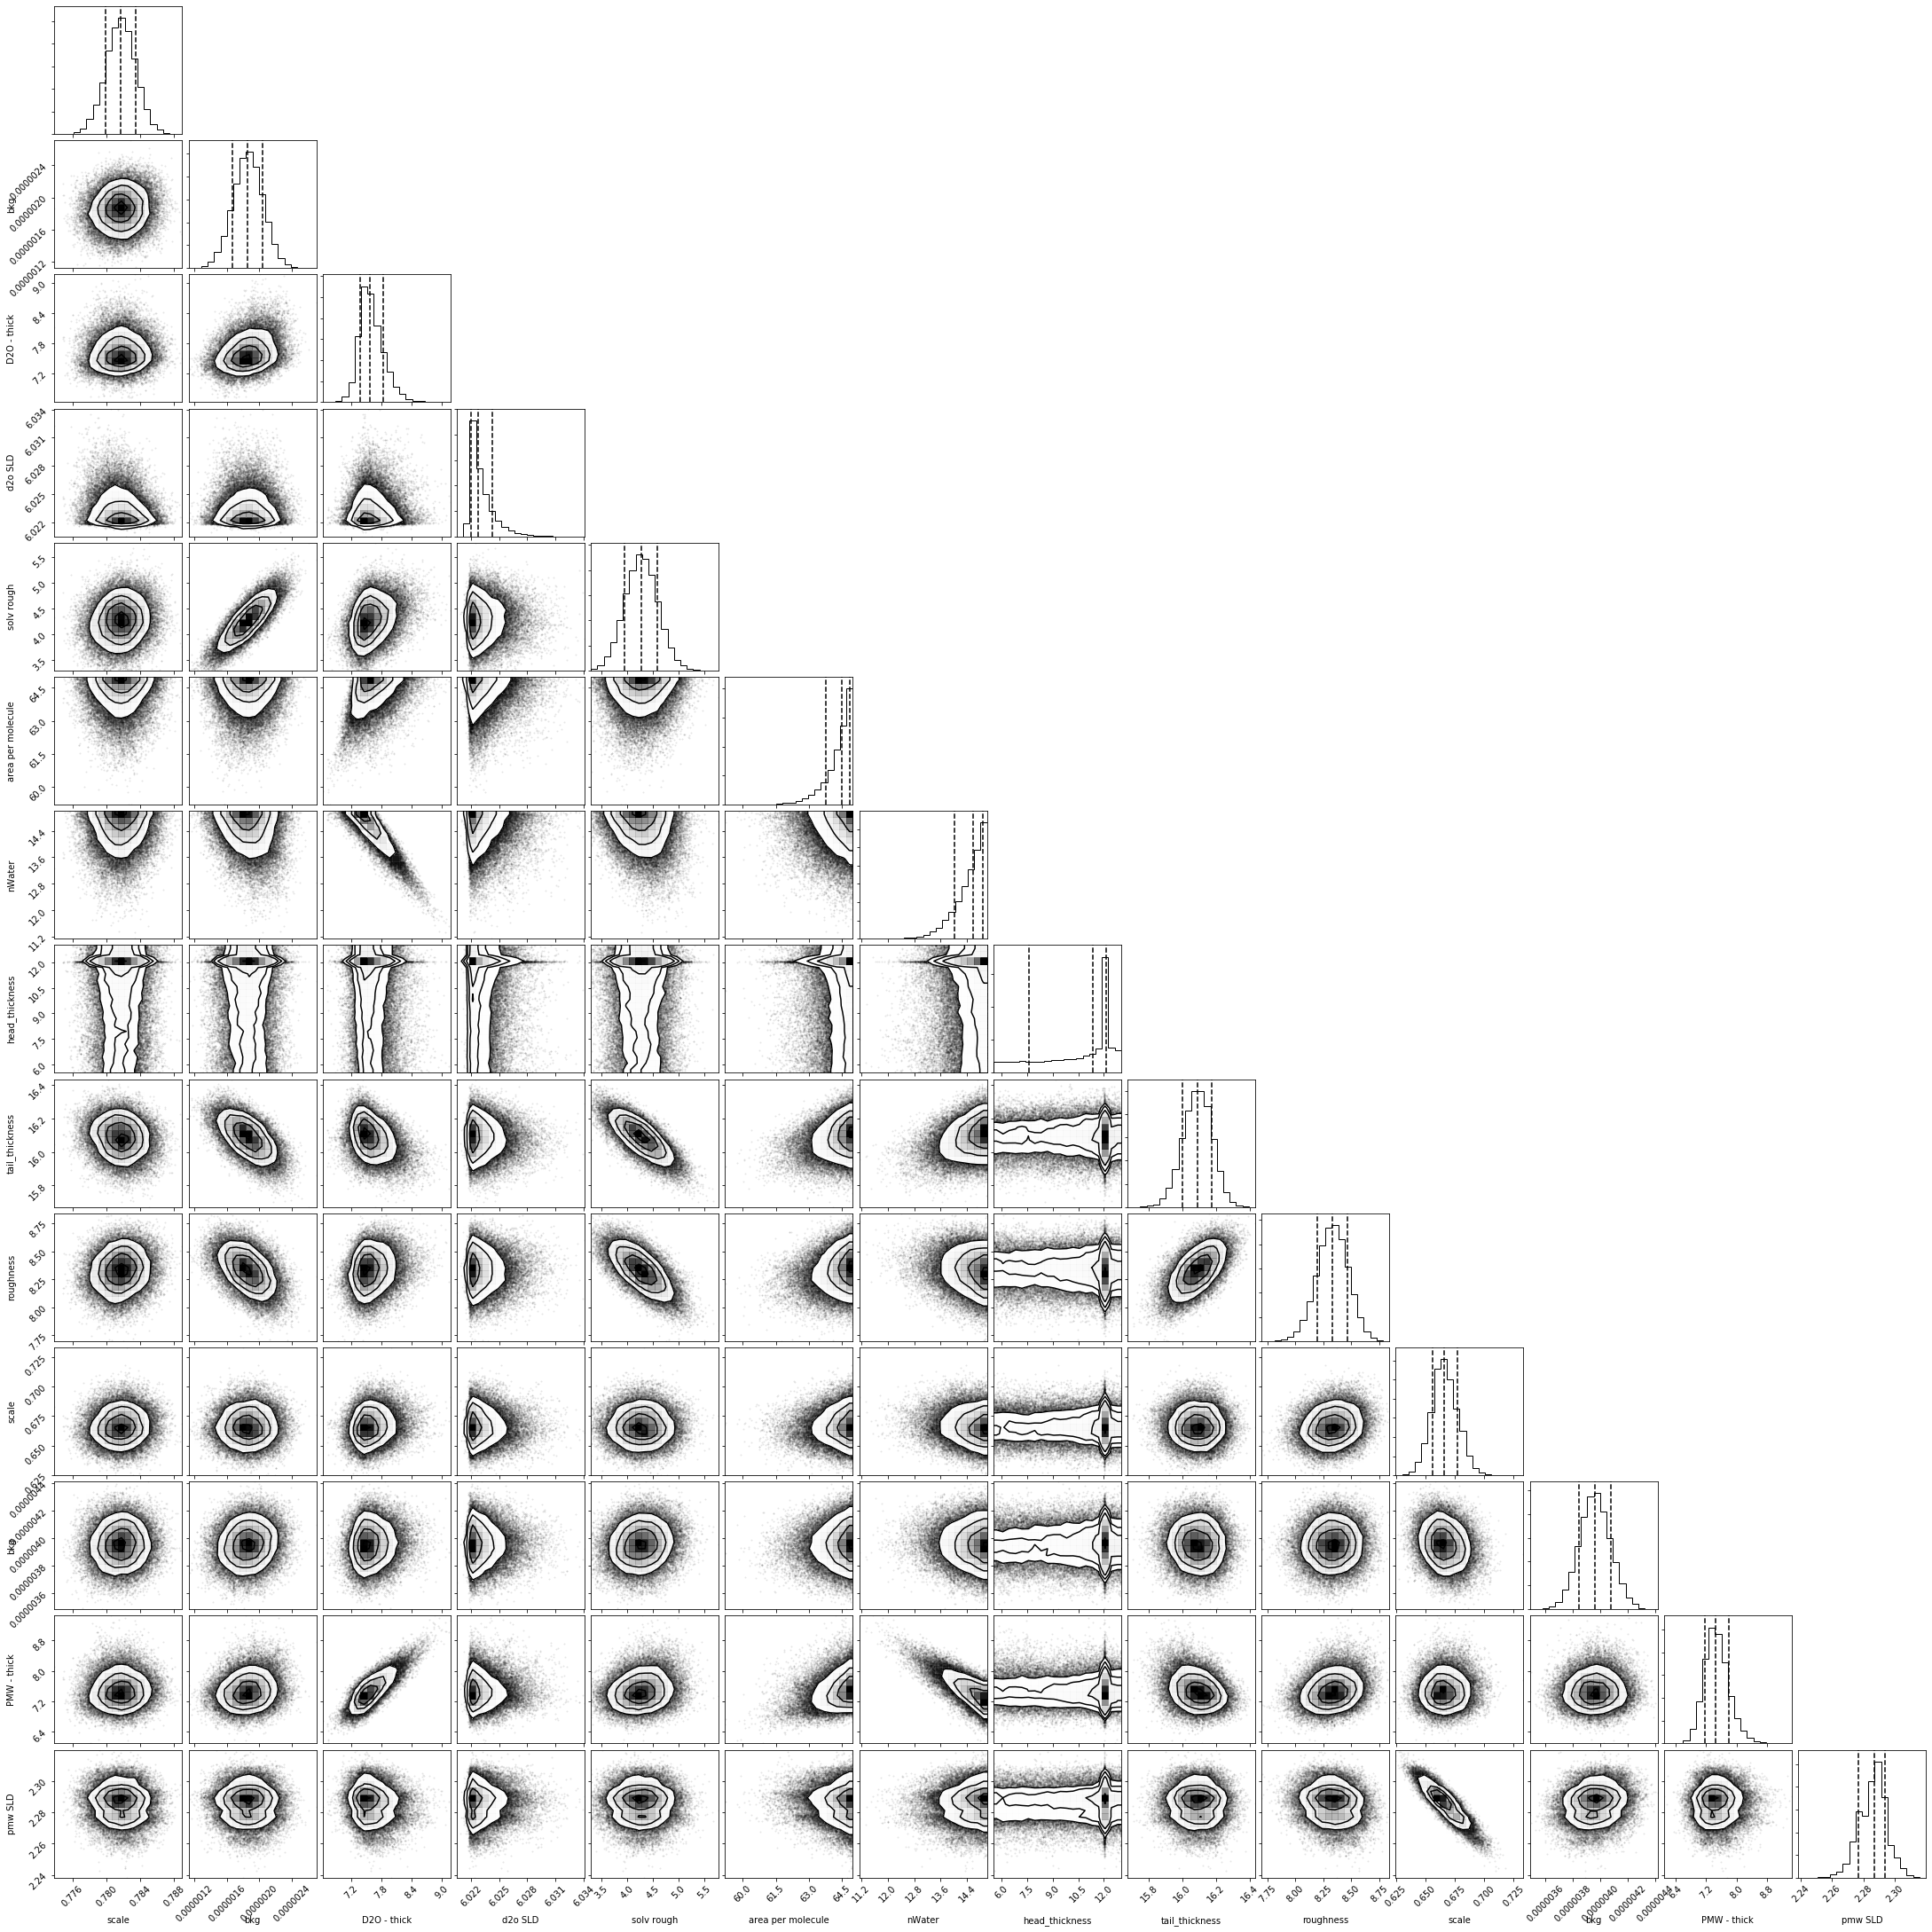

In [10]:
globalObj.corner()
plt.savefig('cornerCustom.png');

In [11]:
print(globalObj.parameters)

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.781694 +/- 0.00175, bounds=[0.6, 0.8]>
<Parameter:     'bkg'     , value=1.8578e-06 +/- 1.87e-07, bounds=[1e-06, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Paramet

/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


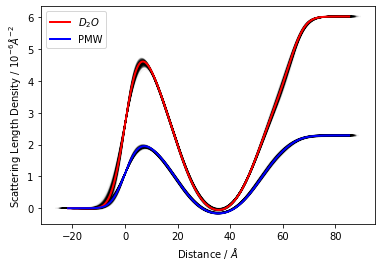

In [13]:
#Compare SLD profiles.
zD2O, median_sldD2O = structD2O.sld_profile()
zPMW, median_sldPMW = structPMW.sld_profile()

for pvec1 in objD2O.pgen(ngen=300):
    objD2O.setp(pvec1)
    zs1, sld1 = structD2O.sld_profile()
    plt.plot(zs1, sld1, color='k', alpha=0.05)
    
for pvec in objPMW.pgen(ngen=300):
    objPMW.setp(pvec)
    zs, sld = structPMW.sld_profile()
    plt.plot(zs, sld, color='k', alpha=0.05)
    
plt.plot(zD2O, median_sldD2O, lw=2, color='r', label = '$D_2O$')
plt.plot(zPMW, median_sldPMW, lw=2, color='b', label = 'PMW')
plt.ylabel('Scattering Length Density / $10^{-6}\AA^{-2}$')
plt.xlabel('Distance / $\AA$')
plt.legend()
plt.savefig('sldCustom.png');

In [14]:
headThick = head_thickness.value
tailThick = tail_thickness.value

frac = 1 - ((tailThick*v_heads.value)/(v_tails.value*headThick))
Water = (frac*v_heads.value)/(29.9*(1 - frac))

print('Solvent fraction: {:.5f}\nWaters per head: {:.0f}'.format(frac, Water))

Solvent fraction: 0.52946
Waters per head: 12


In [15]:
Water = nWater.value

frac = 1 - v_heads.value/(v_heads.value + 29.9*Water)

print('Solvent fraction: {:.5f}\nWaters per head (fit): {:.0f}'.format(frac, Water))

Solvent fraction: 0.56679
Waters per head (fit): 14


In [16]:
globalObj.logl()

926.777994259087

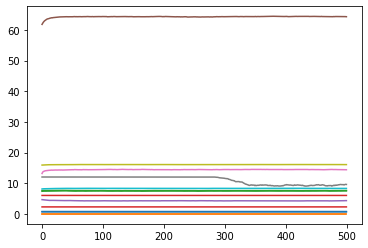

In [18]:
#Shapiro-Wilk test.
from scipy.stats import shapiro
chain = fitCustom.chain

temp2 = []
for param in range (chain.shape[2]):
    temp1 = []
    for sample in range(chain.shape[0]):    
        temp = []
        for val in range (chain.shape[1]):
            temp.append(chain[sample][val][param])
        temp1.append(np.mean(temp))
    temp2.append(temp1)

test = []

for dist in temp2:
    plt.plot(dist)
    test.append(shapiro(dist))

In [19]:
test

[(0.9862202405929565, 0.00011353169975336641),
 (0.6722402572631836, 6.212045282061688e-30),
 (0.9541409015655518, 2.3978874441610287e-11),
 (0.768218994140625, 5.8145544491305e-26),
 (0.6713955402374268, 5.789143415878786e-30),
 (0.35874223709106445, 1.778208234611499e-38),
 (0.49111348390579224, 2.0887263266462112e-35),
 (0.6828583478927612, 1.5259546190962176e-29),
 (0.5488883256912231, 7.364192009638349e-34),
 (0.6636650562286377, 3.0566815947934967e-30),
 (0.9906015992164612, 0.0028289533220231533),
 (0.9873238205909729, 0.0002450025640428066),
 (0.9859865307807922, 9.678742935648188e-05),
 (0.9819268584251404, 7.1626609496888705e-06)]